# Libraries

In [45]:
import pickle
import pandas as pd
import seaborn as sns

from textblob import TextBlob

import nltk
from nltk.corpus import opinion_lexicon

#from sklearn.neighbors import KNeighborsClassifier
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.preprocessing import StandardScaler

from os.path import exists
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix


# Loading the Files

Download the csv files into the `data/` directory.

In [46]:
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

# print("train.csv shape is ", trainingSet.shape)
# print("test.csv shape is ", testingSet.shape)
# print()
# print(trainingSet.head())
# print()
# print(testingSet.head())
# print()
# print(trainingSet.describe())
# trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
# plt.show()
# print()
# print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

# Adding Features

In [47]:
nltk.download('opinion_lexicon')
positive_words = set(opinion_lexicon.positive())
negative_words = set(opinion_lexicon.negative())

def getSubjectivity(text):
   return TextBlob(text).sentiment.subjectivity
  
def getPolarity(text):
   return TextBlob(text).sentiment.polarity

def add_features_to(df):

    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)

    df['SummaryLength'] = df['Summary'].fillna("").str.len()
    df['TextLength'] = df['Text'].fillna("").str.len()

    df['TextSubjectivity'] = df['Text'].fillna("").apply(getSubjectivity)
    df['TextPolarity'] = df['Text'].fillna("").apply(getPolarity)

    df['ExclamationCount'] = df['Text'].fillna("").apply(lambda x: x.count("!"))
    df['PositiveWordCount'] = df['Text'].fillna("").apply(lambda x: sum(1 for word in x.split() if word.lower() in positive_words))
    df['NegativeWordCount'] = df['Text'].fillna("").apply(lambda x: sum(1 for word in x.split() if word.lower() in negative_words))
    df['PosNegRatio'] = df['PositiveWordCount'] / (df['NegativeWordCount'] + 1)

    df['UserAvgRating'] = df.groupby('UserId')['Score'].transform('mean')
    df['ProductAvgRating'] = df.groupby('ProductId')['Score'].transform('mean')
    df['UserReviewCount'] = df.groupby('UserId')['Score'].transform('count')
    df['ProductReviewCount'] = df.groupby('ProductId')['Score'].transform('count')

    avg_rating = df['Score'].mean()
    df['UserDeviation'] = df['UserAvgRating'] - avg_rating
    df['ProductDeviation'] = df['ProductAvgRating'] - avg_rating

    return df

# Load the feature extracted files if they've already been generated
if exists('./data/X_train.csv'):
    X_train = pd.read_csv("./data/X_train.csv")
if exists('./data/X_submission.csv'):
    X_submission = pd.read_csv("./data/X_submission.csv")

else:
    # Process the DataFrame
    train = add_features_to(trainingSet)

    # Merge on Id so that the submission set can have feature columns as well
    X_submission = pd.merge(train, testingSet, left_on='Id', right_on='Id')
    X_submission = X_submission.drop(columns=['Score_x'])
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})

    # The training set is where the score is not null
    X_train =  train[train['Score'].notnull()]

    X_submission.to_csv("./data/X_submission.csv", index=False)
    X_train.to_csv("./data/X_train.csv", index=False)

[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     C:\Users\etanm\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\opinion_lexicon.zip.


# Sample + Split into training and testing set

In [48]:
# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train.drop(columns=['Score']),
    X_train['Score'],
    test_size=1/4.0,
    random_state=0
)

# Feature Selection

In [50]:
features = ['HelpfulnessNumerator',
            'HelpfulnessDenominator',
            'Helpfulness',
            'SummaryLength',
            'TextLength',
            'TextSubjectivity',
            'TextPolarity',
            'ExclamationCount',
            'PositiveWordCount',
            'NegativeWordCount',
            'PosNegRatio',
            'UserAvgRating',
            'ProductAvgRating',
            'UserReviewCount',
            'ProductReviewCount',
            'UserDeviation',
            'ProductDeviation'
            ]

X_train_select = X_train[features]
X_test_select = X_test[features]
X_submission_select = X_submission[features]

print(X_train_select[:5])

scaler = StandardScaler()
X_train_select = scaler.fit_transform(X_train[features])
X_test_select = scaler.transform(X_test[features])
X_submission_select = scaler.transform(X_submission[features])

#print(X_train_select[:5])

         HelpfulnessNumerator  HelpfulnessDenominator  Helpfulness  \
131283                     13                      13         1.00   
1202017                     1                       1         1.00   
511808                      6                      10         0.60   
955172                      3                       4         0.75   
735507                      0                       0         0.00   

         SummaryLength  TextLength  TextSubjectivity  TextPolarity  \
131283              53        3707          0.534209      0.098611   
1202017             16         720          0.585465      0.193842   
511808               8         295          0.588889     -0.091667   
955172              36        2255          0.345455      0.058081   
735507              18         363          0.511111      0.422222   

         ExclamationCount  PositiveWordCount  NegativeWordCount  PosNegRatio  \
131283                  0                 26                 31     0.812500  

# Model Creation

In [52]:
# Learn the model
#model = KNeighborsClassifier(n_neighbors=9).fit(X_train_select, Y_train)
#model = RandomForestClassifier().fit(X_train_select, Y_train)
#model = RandomForestClassifier(max_depth=10, max_features='sqrt', n_estimators=200).fit(X_train_select, Y_train)
#model = MultinomialNB().fit(X_train_select, Y_train)
#model = LogisticRegression().fit(X_train_select, Y_train)
#model = GradientBoostingClassifier(n_estimators=200).fit(X_train_select, Y_train)
model = GradientBoostingClassifier().fit(X_train_select, Y_train)

# Predict on the test set
Y_test_predictions = model.predict(X_test_select)


# Model Evaluation

Accuracy on testing set =  0.6257055604627615


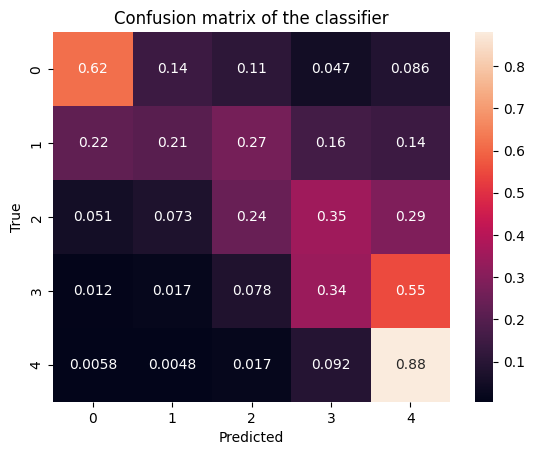

In [56]:
# Evaluate your model on the testing set
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Create submission file

In [68]:
import numpy as np
X_submission_select = np.nan_to_num(X_submission_select, nan=np.nanmean(X_submission_select, axis=0))

# Create the submission file
X_submission['Score'] = model.predict(X_submission_select)
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)